# **NLP 2 Spring 2024: Project B. MBR decoding for Autoregressive and Non-Autoregressive Neural Machine Translation**

Jochem Brandsema

University of Amsterdam

jochem.brandsema@student.uva.nl

## Prerequisites

In [1]:
import os
!git clone https://github.com/JochemBrandsema/fairseq_easy_extend.git
os.chdir('fairseq_easy_extend')

Cloning into 'fairseq_easy_extend'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 271 (delta 79), reused 69 (delta 48), pack-reused 151
Receiving objects: 100% (271/271), 100.92 KiB | 1.02 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!pip install fairseq
!pip install sacremoses
!pip install sentencepiece
!pip install unbabel-comet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 47.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia

In [4]:
def extract_hypotheses(path, num_samples):
  """
  Reads the samples from a file and returns them in a nested list, where each
  element is the list of samples for one source sentence.

  Arguments:
    path: path to file containing sampling output
    num_samples: number of samples per source sentence

  Returns:
    hypss: list of lists of hypotheses
  """
  with open(path, mode='r') as f:
    lines = f.read().splitlines()
  hypss = [lines[i:i + num_samples] for i in range(0, len(lines), num_samples)]
  return hypss

In [5]:
from tqdm import tqdm
from sacrebleu.metrics import BLEU, CHRF

def MBR_find_best(hypss, utility_function='bleu'):
  """
  Finds the best hypothesis using MBR with BLEU or CHRF as utility function.

  Arguments:
    hypss: list of lists of hypotheses
    metric: metric to use as utility function, either 'blue' or 'chrf' (uses chrf++)

  Returns:
    best_hyps: list of best hypotheses
  """
  if utility_function != 'bleu' and utility_function != 'chrf':
    raise ValueError('Available utility functions are \'bleu\' and \'chrf\'')

  best_hyps = []

  for hyps in tqdm(hypss):
    if utility_function == 'bleu':
      u = BLEU(references=[hyps]) # cache references for efficiency
    elif utility_function == 'chrf':
      u = CHRF(word_order=2, references=[hyps]) # CHRF++

    best_hyp = ""
    best_score = 0

    for hyp in hyps:
      score = u.corpus_score([hyp] * len(hyps), None).score # compute score
      if score > best_score: # update
        best_hyp = hyp
        best_score = score
    best_hyps.append(best_hyp)
  return best_hyps

## AR beam search

### Decoding

In [9]:
!python decode_interactive.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/fairseq-data-roen \
--beam 5 \
--path /content/drive/MyDrive/NLP2-ET-2024/data_and_model/ro_en_checkpoint_best.pt \
--input /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.tok.tc.spm.ro \
> /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam_tokenized.txt

2024-05-24 21:08:47.117351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 21:08:47.117412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 21:08:47.246865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 21:08:47.496478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 21:08:49.889965: W tensorflow/compiler/tf2

### Post-processing


1. Remove spm tokenization using `sentencepiece` library
2. remove punctuation tokenization with `sacremoses`
3. remove truecasing with `sacremoses`
4. Write results into the file
5. Remove trailing empty lines


In [10]:
%%bash
python /content/drive/MyDrive/NLP2-ET-2024/data_and_model/spm_decode.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam_tokenized.txt /content/drive/MyDrive/NLP2-ET-2024/data_and_model/sentence.bpe.model | \
sacremoses -l en detokenize | \
sacremoses -l en detruecase > /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt

wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt
sed -i -e :a -e '/^\n*$/{$d;N;ba' -e '}' /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt
wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt

2000 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt
1999 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt


## AR MBR

### Sampling

In [16]:
!python decode_interactive.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/fairseq-data-roen \
--beam 100 \
--sampling \
--sampling-topk 10 \
--nbest 100 \
--path /content/drive/MyDrive/NLP2-ET-2024/data_and_model/ro_en_checkpoint_best.pt \
--input /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.tok.tc.spm.ro \
--temperature 1.0 \
> /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling_tokenized.txt

2024-05-24 21:26:07.810383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 21:26:07.810445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 21:26:07.954393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 21:26:08.219326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 21:26:10.825729: W tensorflow/compiler/tf2

### Post-processing

In [17]:
%%bash
python /content/drive/MyDrive/NLP2-ET-2024/data_and_model/spm_decode.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling_tokenized.txt /content/drive/MyDrive/NLP2-ET-2024/data_and_model/sentence.bpe.model | \
sacremoses -l en detokenize | \
sacremoses -l en detruecase > /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt

wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt
sed -i -e :a -e '/^\n*$/{$d;N;ba' -e '}' /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt
wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt

199901 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt
199900 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt


### Hypothesis selection

#### BLEU

In [61]:
hypss = extract_hypotheses('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt', 100)
best_hyps = MBR_find_best(hypss, 'bleu')
with open('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_bleu.txt', mode='w') as f:
  f.write('\n'.join(best_hyps) + '\n')

100%|██████████| 1999/1999 [30:01<00:00,  1.11it/s]


#### CHRF++

In [81]:
hypss = extract_hypotheses('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt', 100)
best_hyps = MBR_find_best(hypss, 'chrf')

with open('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_chrf.txt', mode='w') as f:
  f.write('\n'.join(best_hyps) + '\n')

100%|██████████| 1999/1999 [2:24:02<00:00,  4.32s/it]


#### COMET

In [18]:
!comet-mbr -s /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.ro -t /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_sampling.txt --num_sample 100 --gpus 1 -o /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_comet.txt

Fetching 5 files: 100% 5/5 [00:00<00:00, 62230.03it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
Encoding sentences...: 100% 6247/6247 [24:57<00:00,  4.17it/s]
MBR Scores...: 100% 1999/1999 [06:15<00:00,  5.33

## NAR mask-predict

In this project we use CMLM proposed in [Mask-Predict: Parallel Decoding of Conditional Masked Language Models](https://aclanthology.org/D19-1633) (Ghazvininejad et al., EMNLP-IJCNLP 2019)

### Decoding

In [21]:
!python decode_interactive.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/fairseq-data-roen \
--task translation_lev \
--iter-decode-max-iter 4 \
--iter-decode-eos-penalty 0 \
--iter-decode-force-max-iter \
--path  /content/drive/MyDrive/NLP2-ET-2024/data_and_model/cmlm_checkpoint_best.pt \
--input /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.tok.tc.spm.ro \
> /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask_tokenized.txt

2024-05-24 22:24:26.337254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 22:24:26.337323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 22:24:26.338935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 22:24:26.346611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 22:24:27.562491: W tensorflow/compiler/tf2

### Post-processing

In [7]:
#post-processing and evaluation are the same as for AR model
%%bash
python /content/drive/MyDrive/NLP2-ET-2024/data_and_model/spm_decode.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask_tokenized.txt /content/drive/MyDrive/NLP2-ET-2024/data_and_model/sentence.bpe.model | \
sacremoses -l en detokenize | \
sacremoses -l en detruecase > /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask.txt

wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask.txt
sed -i -e :a -e '/^\n*$/{$d;N;ba' -e '}' /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask.txt
wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask.txt

2000 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask.txt
1999 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_mask.txt


## NAR MBR

### Sampling

In [6]:
!python decode_interactive.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/fairseq-data-roen \
--task translation_lev \
--path  /content/drive/MyDrive/NLP2-ET-2024/data_and_model/cmlm_checkpoint_best.pt \
--iter-decode-max-iter 4 \
--iter-decode-eos-penalty 0 \
--nbest 100 \
--sampling \
--sampling-topk 10 \
--input /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.tok.tc.spm.ro \
--temperature 1.0 \
--iter-decode-with-beam 100 \
--iter-decode-force-max-iter \
> /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling_tokenized.txt

2024-05-30 17:01:25.026698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 17:01:25.026750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 17:01:25.028154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 17:01:25.035994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 17:01:26.090809: W tensorflow/comp

### Post-processing

In [7]:
%%bash
python /content/drive/MyDrive/NLP2-ET-2024/data_and_model/spm_decode.py /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling_tokenized.txt /content/drive/MyDrive/NLP2-ET-2024/data_and_model/sentence.bpe.model | \
sacremoses -l en detokenize | \
sacremoses -l en detruecase > /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt

wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt
sed -i -e :a -e '/^\n*$/{$d;N;ba' -e '}' /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt
wc -l /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt

199901 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt
199900 /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt


### Hypothesis selection

#### BLEU

In [6]:
hypss = extract_hypotheses('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt', 100)
best_hyps = MBR_find_best(hypss, 'bleu')

with open('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_bleu.txt', mode='w') as f:
  f.write('\n'.join(best_hyps) + '\n')

100%|██████████| 1999/1999 [30:50<00:00,  1.08it/s]


#### CHRF++

In [7]:
hypss = extract_hypotheses('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt', 100)
best_hyps = MBR_find_best(hypss, 'chrf')

with open('/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_chrf.txt', mode='w') as f:
  f.write('\n'.join(best_hyps) + '\n')

100%|██████████| 1999/1999 [2:24:57<00:00,  4.35s/it]


#### COMET

In [10]:
!comet-mbr -s /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.ro -t /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_sampling.txt --num_sample 100 --gpus 1 -o /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_comet.txt

Fetching 5 files: 100% 5/5 [00:00<00:00, 63743.22it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
Encoding sentences...: 100% 6247/6247 [25:14<00:00,  4.13it/s]
MBR Scores...: 100% 1999/1999 [06:37<00:00,  5.03

## Evaluation

In [8]:
!sacrebleu /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.en -i /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/*ar_output_*[!dg].txt -m bleu chrf --chrf-word-order 2

sacreBLEU: Found 8 systems.
[
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt",
        "BLEU": "31.2",
        "chrF2++": "55.6"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_bleu.txt",
        "BLEU": "30.8",
        "chrF2++": "55.2"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_chrf.txt",
        "BLEU": "29.7",
        "chrF2++": "55.7"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_comet.txt",
        "BLEU": "29.8",
        "chrF2++": "54.9"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_bleu.txt",
        "BLEU": "28.0",
        "chrF2++": "53.3"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_chrf.txt",
        "BLEU": "27.2",
        "chrF2++": "53.9"
    },
    {
       

In [9]:
!sacrebleu /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.en -i /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/*ar_output_*[!dg].txt -m chrf ter

sacreBLEU: Found 8 systems.
[
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_beam.txt",
        "chrF2": "57.5",
        "TER": "56.1"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_bleu.txt",
        "chrF2": "57.0",
        "TER": "56.2"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_chrf.txt",
        "chrF2": "57.6",
        "TER": "58.1"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/ar_output_comet.txt",
        "chrF2": "56.8",
        "TER": "56.9"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_bleu.txt",
        "chrF2": "55.2",
        "TER": "58.1"
    },
    {
        "system": "/content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/nar_output_chrf.txt",
        "chrF2": "56.0",
        "TER": "59.7"
    },
    {
        "system": "/conte

In [5]:
!comet-score -s /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.ro -t /content/drive/MyDrive/NLP2-ET-2024/data_and_model/eval/*ar_output_*[!dg].txt -r /content/drive/MyDrive/NLP2-ET-2024/data_and_model/newstest2016.en --only_system

Seed set to 1
Fetching 5 files: 100% 5/5 [00:00<00:00, 72315.59it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoder model frozen.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: Fal

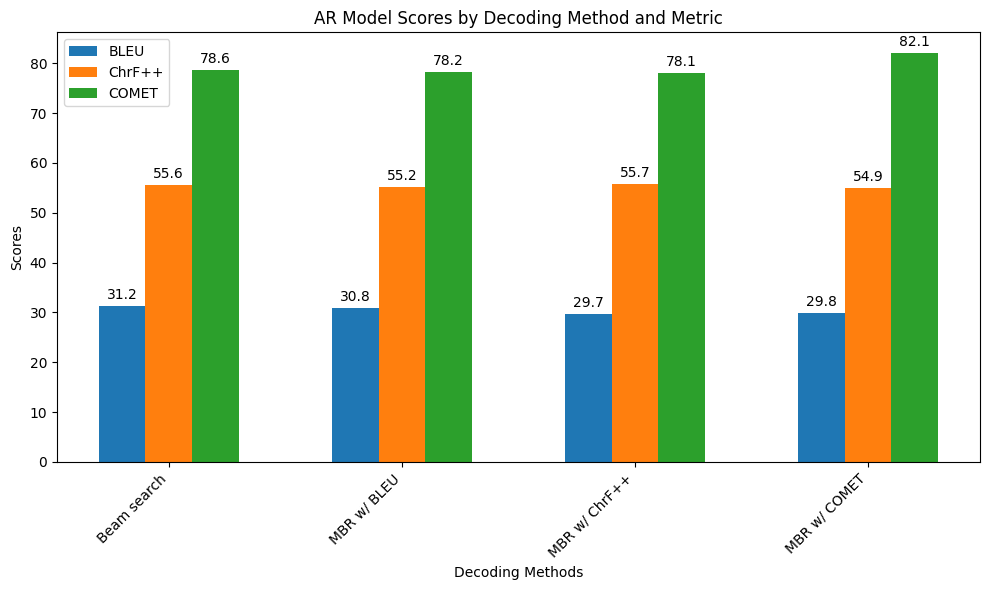

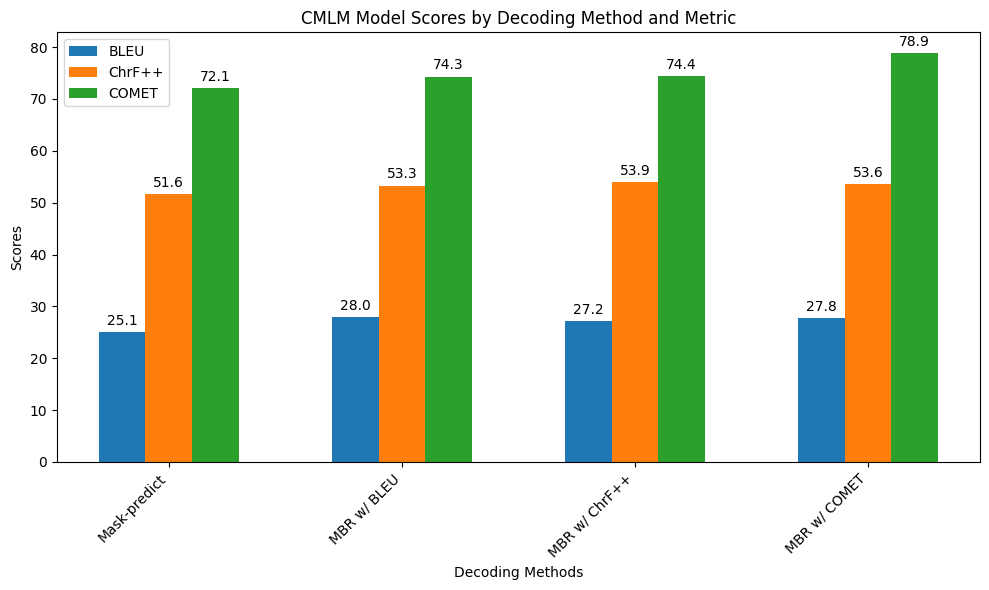

In [1]:
# Code in this cell courtesy of ChatGPT (with some minor adjustments)
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
decoding_methods_AR = ['Beam search', 'MBR w/ BLEU', 'MBR w/ ChrF++', 'MBR w/ COMET']
decoding_methods_CMLM = ['Mask-predict', 'MBR w/ BLEU', 'MBR w/ ChrF++', 'MBR w/ COMET']
ar_scores = {
    'BLEU': [31.2, 30.8, 29.7, 29.8],
    'ChrF++': [55.6, 55.2, 55.7, 54.9],
    'COMET': [78.6, 78.2, 78.1, 82.1]
}
cmlm_scores = {
    'BLEU': [25.1, 28.0, 27.2, 27.8],
    'ChrF++': [51.6, 53.3, 53.9, 53.6],
    'COMET': [72.1, 74.3, 74.4, 78.9]
}

# Function to create bar plot for each metric
def plot_scores(scores, model_name, methods):
    x = np.arange(len(methods))  # label locations
    width = 0.2  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, scores['BLEU'], width, label='BLEU')
    rects2 = ax.bar(x, scores['ChrF++'], width, label='ChrF++')
    rects3 = ax.bar(x + width, scores['COMET'], width, label='COMET')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Decoding Methods')
    ax.set_ylabel('Scores')
    ax.set_title(f'{model_name} Scores by Decoding Method and Metric')
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45, ha="right")
    ax.legend()

    # Attach a text label above each bar in rects, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

# Plot AR model scores
plot_scores(ar_scores, 'AR Model', decoding_methods_AR)

# Plot CMLM scores
plot_scores(cmlm_scores, 'CMLM Model', decoding_methods_CMLM)
